# Análisis Exploratorio de Clustering en Noticias Falsas y Reales

En este notebook se aplica un análisis no supervisado sobre un conjunto de noticias etiquetadas como verdaderas o falsas. El objetivo es explorar si existen patrones en los textos que permitan agruparlos por temas mediante técnicas de clustering como K-Means. 



## 1. Importación de librerías necesarias

Se importan las bibliotecas estándar para el análisis de texto, clustering, reducción de dimensionalidad y visualización.


In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../src')  # Añades esa carpeta al path
import nltk
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from nltk.corpus import stopwords, wordnet
import seaborn as sns
from sklearn.metrics import silhouette_score
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
import ast
import re

## 2. Carga del dataset WELFake


In [2]:
df = pd.read_csv("../data/processed/WELFake_only_english.csv")
df.drop(columns=['Unnamed: 0', 'sentences_clean'], inplace=True)
df.head(5)

,title,text,label,news_type,title_length,sentences,lang
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,Real,130,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,en
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,Real,137,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,en
2,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,Falsa,105,"Bobby Jindal, raised Hindu, uses story of Chri...",en
3,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,Real,95,SATAN 2: Russia unvelis an image of its terrif...,en
4,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,Real,78,About Time! Christian Group Sues Amazon and SP...,en


## 3. Limpieza y preprocesamiento de texto

Se aplica un preprocesamiento básico del texto que incluye: conversión a minúsculas, eliminación de URLs, menciones, hashtags, signos de puntuación y caracteres especiales, así como limpieza de espacios en blanco. A continuación, se realiza una tokenización seguida de la eliminación de palabras vacías (stopwords) y de tokens muy cortos. Luego, se aplica una lematización basada en etiquetas gramaticales, descartando verbos y adverbios, con el fin de conservar únicamente palabras significativas como sustantivos y adjetivos.



In [3]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')


[nltk_data] Downloading package punkt to /home/inma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/inma/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/inma/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [4]:
df = df.drop_duplicates(subset='title', keep='first')
df.shape

(61856, 7)

In [5]:
df['sentences'] = df['sentences'].apply(lambda x: ' '.join(x.split()[:200]))


In [5]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r"http\S+|www\S+", "", texto)
    texto = re.sub(r'@\w+|#\w+', '', texto)  # menciones y hashtags
    texto = re.sub(r"[^a-z\s]", " ", texto)  # solo letras y espacios
    texto = re.sub(r"\s+", " ", texto).strip()  # quitar espacios múltiples
    return texto

def nltk_pos_to_wn(pos_tag):
    if pos_tag.startswith("N"):
        return wordnet.NOUN
    elif pos_tag.startswith("J"):
        return wordnet.ADJ
    elif pos_tag.startswith("V"):
        return wordnet.VERB
    elif pos_tag.startswith("R"):
        return wordnet.ADV
    else:
        return None
def procesar_texto(texto):
    texto = limpiar_texto(texto)
    tokens = word_tokenize(texto)
    tokens = [w for w in tokens if w not in stop_words and len(w) > 2]

    tagged = pos_tag(tokens)
    tokens_filtrados = []
    for word, tag in tagged:
        if tag.startswith(("V", "R")):
            continue  # eliminamos verbos y adverbios
        wn_tag = nltk_pos_to_wn(tag)
        if wn_tag:
            lema = lemmatizer.lemmatize(word, wn_tag)
        else:
            lema = word
        tokens_filtrados.append(lema)
    
    return tokens_filtrados


In [6]:
clean_data = df['sentences'].apply(procesar_texto)

In [ ]:
clean_data

0        law enforcement high alert threat white fyf te...
1        unbelievable obamas attorney general charlotte...
2        bobby jindal hindu us story christian conversi...
3        satan russia unvelis image new supernuke weste...
4        time christian group sue splc designation hate...
                               ...                        
71063    wikileaks email clinton foundation fund lavish...
71065    russian research trump hack democratic party w...
71066    watch giuliani democrat trump birtherism fanta...
71067    migrant train refugee camp hungary migrant tra...
71068    trump tussle unpopular mexican leader shot arm...
Name: sentences, Length: 61858, dtype: object

Lo guardamos ya que tarda mucho y si lo volvemos a necesitar no queremos derrochar otra media hora

In [ ]:
# Convertir a lista de strings
df["no_verbs"] = clean_data.apply(lambda x: ' '.join(x))
df.to_csv("../data/processed/data_preprocess.csv", index=False)
df

,title,text,label,news_type,title_length,sentences,lang,no_verbs
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,Real,130,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,en,law enforcement high alert threat white terror...
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,Real,137,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,en,unbelievable obama attorney general charlotte ...
2,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,Falsa,105,"Bobby Jindal, raised Hindu, uses story of Chri...",en,bobby jindal hindu us story christian conversi...
3,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,Real,95,SATAN 2: Russia unvelis an image of its terrif...,en,satan russia unvelis image new supernuke weste...
4,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,Real,78,About Time! Christian Group Sues Amazon and SP...,en,time christian group sue splc designation hate...
...,...,...,...,...,...,...,...,...
71063,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,An email released by WikiLeaks on Sunday appea...,1,Real,104,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,en,wikileaks email clinton foundation fund lavish...
71065,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0,Falsa,65,Russians steal research on Trump in hack of U....,en,russian research trump hack democratic party w...
71066,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1,Real,79,WATCH: Giuliani Demands That Democrats Apologi...,en,watch giuliani democrat trump racist birtheris...
71067,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0,Falsa,57,Migrants Refuse To Leave Train At Refugee Camp...,en,migrant train refugee camp hungary migrant tra...


In [6]:
df= pd.read_csv("../data/processed/data_preprocess.csv")
df

,title,text,label,news_type,title_length,sentences,lang,no_verbs
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,Real,130,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,en,law enforcement high alert threat white terror...
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,Real,137,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,en,unbelievable obama attorney general charlotte ...
2,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,Falsa,105,"Bobby Jindal, raised Hindu, uses story of Chri...",en,bobby jindal hindu us story christian conversi...
3,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,Real,95,SATAN 2: Russia unvelis an image of its terrif...,en,satan russia unvelis image new supernuke weste...
4,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,Real,78,About Time! Christian Group Sues Amazon and SP...,en,time christian group sue splc designation hate...
...,...,...,...,...,...,...,...,...
61853,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,An email released by WikiLeaks on Sunday appea...,1,Real,104,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,en,wikileaks email clinton foundation fund lavish...
61854,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0,Falsa,65,Russians steal research on Trump in hack of U....,en,russian research trump hack democratic party w...
61855,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1,Real,79,WATCH: Giuliani Demands That Democrats Apologi...,en,watch giuliani democrat trump racist birtheris...
61856,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0,Falsa,57,Migrants Refuse To Leave Train At Refugee Camp...,en,migrant train refugee camp hungary migrant tra...


La idea era eliminar las 100 palabras mas frecuentes peor observandolas me doy cuenta de que tienen importancia para el clustering asi que las dejamos

In [7]:
df = df.dropna(subset=['no_verbs'])


In [8]:
clean_data = df['no_verbs']

## 5. Vectorización con TF-IDF

Se utiliza la técnica TF-IDF (*Term Frequency - Inverse Document Frequency*) para convertir los textos preprocesados en vectores numéricos dispersos. Este método asigna mayor peso a las palabras que son frecuentes en un documento pero poco comunes en el resto del corpus, lo que ayuda a resaltar términos relevantes para la representación del contenido. 

Esta matriz de vectores será utilizada como entrada para los algoritmos de clustering.


In [9]:

vectorizer = TfidfVectorizer(max_features=5000)  # puedes ajustar este número

X = vectorizer.fit_transform(clean_data)

# Obtener el vocabulario (palabras seleccionadas)
words = vectorizer.get_feature_names_out()

print(len(words))
print(words[:50])

5000
['aaron' 'abadi' 'abandon' 'abbas' 'abbott' 'abc' 'abdel' 'abdullah' 'abe'
 'abedin' 'ability' 'able' 'aboard' 'abortion' 'absence' 'absent'
 'absolute' 'absurd' 'abu' 'abuse' 'aca' 'academic' 'academy' 'accept'
 'acceptable' 'acceptance' 'access' 'accident' 'accomplishment' 'accord'
 'account' 'accountability' 'accountable' 'accuracy' 'accurate'
 'accusation' 'accuse' 'accuser' 'achievement' 'aclu' 'acosta'
 'acquisition' 'acr' 'acre' 'across' 'act' 'action' 'active' 'activism'
 'activist']


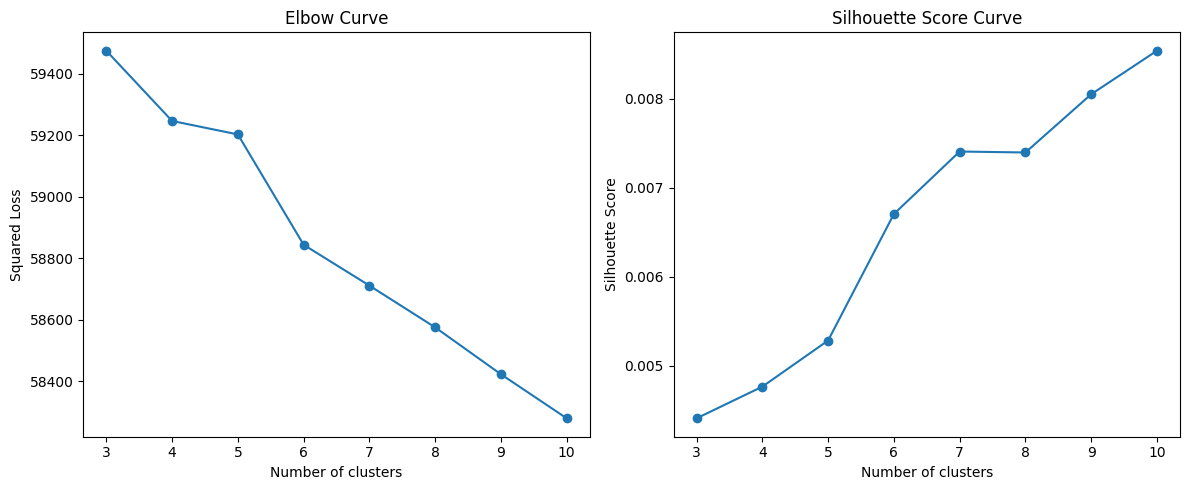

Optimal number of clusters (Elbow method): 10
Optimal number of clusters (Silhouette score): 10
Highest silhouette score: 0.008540855889484354


In [10]:
num_clus = [x for x in range(3, 11)]
squared_errors = []
silhouette_scores = []

for cluster in num_clus:
    kmeans = KMeans(n_clusters=cluster, random_state=30).fit(X)
    squared_errors.append(kmeans.inertia_)

    # Calcular silueta solo si hay más de 1 cluster y menos de n_samples
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

# Mostrar curvas
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(num_clus, squared_errors, marker='o')
plt.title("Elbow Curve")
plt.xlabel("Number of clusters")
plt.ylabel("Squared Loss")

plt.subplot(1, 2, 2)
plt.plot(num_clus, silhouette_scores, marker='o')
plt.title("Silhouette Score Curve")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

# Determinar número óptimo según silueta
optimal_by_silhouette = num_clus[np.argmax(silhouette_scores)]

print("Optimal number of clusters (Elbow method):", num_clus[np.argmin(squared_errors)])
print("Optimal number of clusters (Silhouette score):", optimal_by_silhouette)
print("Highest silhouette score:", max(silhouette_scores))


In [13]:
kmeans = KMeans(n_clusters=6, random_state=30) 
clustered = kmeans.fit_predict(X)
num_words = 25
# We look at 5 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:, -num_words:][:, ::-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : state, reuters, minister, government, president, party, military, united, russian, russia, iran, country, official, syria, force, would, foreign, syrian, leader, islamic, prime, security, european, year, election
1 : clinton, hillary, email, trump, campaign, fbi, election, democratic, sander, presidential, state, candidate, investigation, new, poll, voter, republican, president, donald, bill, obama, secretary, foundation, server, bernie
2 : korea, north, korean, nuclear, missile, china, south, test, pyongyang, sanction, united, trump, state, japan, reuters, kim, president, weapon, ballistic, seoul, program, chinese, military, foreign, tillerson
3 : tax, house, republican, bill, senate, obamacare, would, trump, democrat, vote, legislation, president, healthcare, health, ryan, congress, budget, senator, committee, representative, plan, washington, white, obama, reuters
4 : trump, donald, president, republican, campaign, white, house, election, new, would, presidential, people, one, o

### Temas por Clúster

#### Clúster 0: Geopolítica y conflictos internacionales
**Palabras clave más representativas:**  
`state`, `reuters`, `minister`, `government`, `president`, `party`, `military`, `united`, `russian`, `russia`, `iran`, `country`, `official`, `syria`, `force`, `would`, `foreign`, `syrian`, `leader`, `islamic`, `prime`, `security`, `european`, `year`, `election`

**Tema estimado:**  
Conflictos internacionales, relaciones diplomáticas y seguridad global. Enfocado en actores como Rusia, Irán y Siria, y en el papel de EE.UU. y Europa en cuestiones militares y políticas.

---

#### Clúster 1: Hillary Clinton y las elecciones de 2016
**Palabras clave más representativas:**  
`clinton`, `hillary`, `email`, `trump`, `campaign`, `fbi`, `election`, `democratic`, `sander`, `presidential`, `state`, `candidate`, `investigation`, `new`, `poll`, `voter`, `republican`, `president`, `donald`, `bill`, `obama`, `secretary`, `foundation`, `server`, `bernie`

**Tema estimado:**  
La campaña presidencial de 2016 en EE.UU., centrada en Hillary Clinton. Incluye el escándalo de los correos electrónicos, investigaciones del FBI y figuras clave como Bernie Sanders y Donald Trump.

---

#### Clúster 2: Corea del Norte y tensiones nucleares
**Palabras clave más representativas:**  
`korea`, `north`, `korean`, `nuclear`, `missile`, `china`, `south`, `test`, `pyongyang`, `sanction`, `united`, `trump`, `state`, `japan`, `reuters`, `kim`, `president`, `weapon`, `ballistic`, `seoul`, `program`, `chinese`, `military`, `foreign`, `tillerson`

**Tema estimado:**  
Conflicto con Corea del Norte, desarrollo nuclear y relaciones en Asia-Pacífico. Incluye pruebas de misiles, sanciones internacionales y la participación de EE.UU., China y Japón.

---

#### Clúster 3: Legislación y política fiscal en EE.UU.
**Palabras clave más representativas:**  
`tax`, `house`, `republican`, `bill`, `senate`, `obamacare`, `would`, `trump`, `democrat`, `vote`, `legislation`, `president`, `healthcare`, `health`, `ryan`, `congress`, `budget`, `senator`, `committee`, `representative`, `plan`, `washington`, `white`, `obama`, `reuters`

**Tema estimado:**  
Debates legislativos sobre salud e impuestos, con foco en propuestas republicanas, reforma sanitaria (Obamacare) y la dinámica en el Congreso y Senado de EE.UU.

---

#### Clúster 4: Donald Trump y su imagen pública
**Palabras clave más representativas:**  
`trump`, `donald`, `president`, `republican`, `campaign`, `white`, `house`, `election`, `new`, `would`, `presidential`, `people`, `one`, `obama`, `time`, `state`, `news`, `american`, `video`, `twitter`, `medium`, `like`, `former`, `candidate`, `party`

**Tema estimado:**  
Cobertura centrada en Donald Trump, su presidencia, campaña electoral y manejo de medios. Incluye su interacción con el público y el uso estratégico de redes sociales.

---

#### Clúster 5: Sociedad y actualidad urbana
**Palabras clave más representativas:**  
`new`, `time`, `year`, `people`, `police`, `one`, `state`, `video`, `york`, `court`, `woman`, `like`, `obama`, `american`, `would`, `news`, `day`, `president`, `two`, `black`, `law`, `city`, `right`, `man`, `school`

**Tema estimado:**  
Temas de sociedad, justicia, actualidad y eventos en entornos urbanos. Incluye violencia policial, diversidad, ciudad de Nueva York y asuntos legales o mediáticos de interés general.


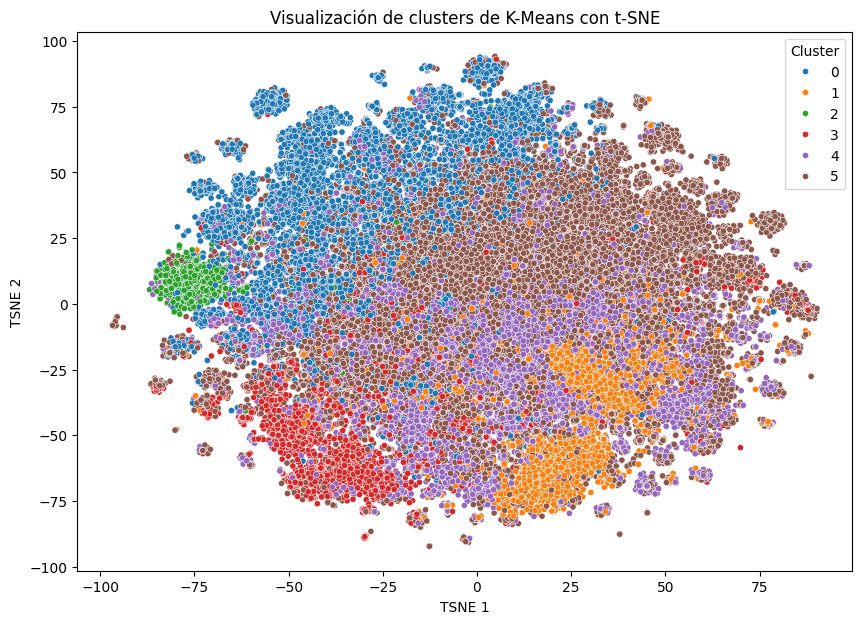

In [14]:
# Reduce dimensiones con t-SNE
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

# Visualiza
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=kmeans.labels_,
    palette="tab10",
    s=20
)
plt.title("Visualización de clusters de K-Means con t-SNE")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.legend(title="Cluster")
plt.show()


In [15]:
df = df.copy()
df['Cluster'] = kmeans.labels_

df.groupby(['Cluster'])['no_verbs'].count()

Cluster
0    11696
1     5277
2     1112
3     4388
4    13191
5    26185
Name: no_verbs, dtype: int64

In [16]:
for i in range(6):
    print("A review of assigned to cluster ", i)
    print("-" * 70)
    for j in range(5):
        print(df.iloc[df.groupby(['Cluster']).groups[i][j]]['title'])
        print('\n')
    print("_" * 70)

A review of assigned to cluster  0
----------------------------------------------------------------------
SATAN 2: Russia unvelis an image of its terrifying new ‘SUPERNUKE’ – Western world takes notice


May Brexit offer would hurt, cost EU citizens - EU parliament


U.N. seeks humanitarian pause in Sanaa where streets "battlegrounds"


BOOM! Danish Government Considers Seizing Migrant’s Valuables To Pay For Benefits


Islamic State driven out of last stronghold in northern Iraq


______________________________________________________________________
A review of assigned to cluster  1
----------------------------------------------------------------------
WATCH: HILARIOUS AD Calls Into Question Health Of Aging Clinton Crime Family Bosses


Second judge says Clinton email setup may have been in 'bad faith'


Hillary’s crime family: End of days for the U.S.A


UNHOLY ALLIANCE: Hillary Clinton’s Saudi Sponsors Support Terrorism, Islamist Extremism


Clinton extends lead over Trump to 7 poi

<Figure size 1000x600 with 0 Axes>

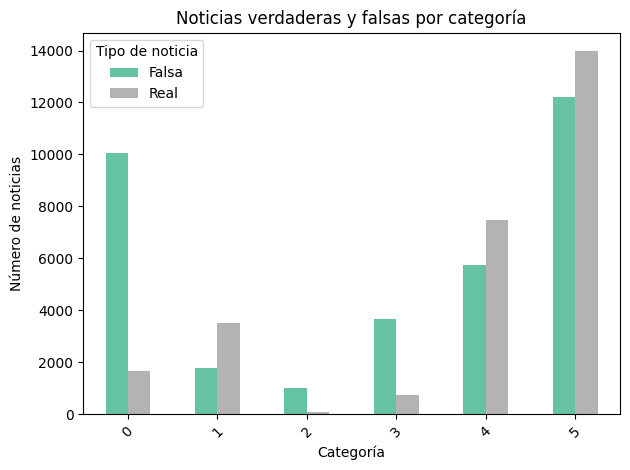

In [23]:
# Contar noticias por categoría y tipo

counts = df.groupby(['Cluster', 'news_type']).size().unstack(fill_value=0)

# Crear gráfico
plt.figure(figsize=(10, 6))
counts.plot(kind='bar', stacked=False, colormap='Set2')
plt.title('Noticias verdaderas y falsas por categoría')
plt.xlabel('Categoría')
plt.ylabel('Número de noticias')
plt.xticks(rotation=45)
plt.legend(title='Tipo de noticia')
plt.tight_layout()
plt.show()

In [21]:
cluster_to_category = {
    0: "gobierno",
    1: "clinton",
    2: "corea",
    3: "sanidad",
    4: "trump",
    5: "sociedad"
}

df['category'] = df['Cluster'].map(cluster_to_category)


In [22]:
df

,title,text,label,news_type,title_length,sentences,lang,no_verbs,Cluster,category
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,Real,130,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,en,law enforcement high alert threat white terror...,5,sociedad
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,Real,137,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,en,unbelievable obama attorney general charlotte ...,5,sociedad
2,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,Falsa,105,"Bobby Jindal, raised Hindu, uses story of Chri...",en,bobby jindal hindu us story christian conversi...,5,sociedad
3,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,Real,95,SATAN 2: Russia unvelis an image of its terrif...,en,satan russia unvelis image new supernuke weste...,0,gobierno
4,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,Real,78,About Time! Christian Group Sues Amazon and SP...,en,time christian group sue splc designation hate...,5,sociedad
...,...,...,...,...,...,...,...,...,...,...
61853,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,An email released by WikiLeaks on Sunday appea...,1,Real,104,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,en,wikileaks email clinton foundation fund lavish...,1,clinton
61854,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0,Falsa,65,Russians steal research on Trump in hack of U....,en,russian research trump hack democratic party w...,1,clinton
61855,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1,Real,79,WATCH: Giuliani Demands That Democrats Apologi...,en,watch giuliani democrat trump racist birtheris...,4,trump
61856,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0,Falsa,57,Migrants Refuse To Leave Train At Refugee Camp...,en,migrant train refugee camp hungary migrant tra...,5,sociedad


In [4]:
df=pd.read_csv("../data/processed/noticias_tema.csv")

In [11]:
df["category"].value_counts()


category
sociedad    26185
trump       13191
gobierno    11696
clinton      5277
sanidad      4388
corea        1112
Name: count, dtype: int64

In [24]:
df.to_csv("../data/processed/noticias_tema.csv", index=False)


In [25]:
import joblib
joblib.dump(kmeans, 'kmeans_model.pkl')
joblib.dump(vectorizer, 'kmeans_vectorizer.pkl') 

['kmeans_vectorizer.pkl']